In [149]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, lfilter

In [150]:
def generateChirp(start, end, sr, dur, samples = None):
    '''
    Generates a chirp signal

    Parameters:
    start (float): start frequency of the chirp
    end (float): end frequency of the chirp
    sr (num): sampling rate
    dur (num):  time duration of tone
    '''
    if samples is None:
        samples = int(sr * dur)
    time = np.linspace(0, dur, samples, False)

    linear_chirp = librosa.chirp(fmin=start, fmax=end, sr = sr, length = samples, duration=dur, linear=True)  
    
    return linear_chirp


In [151]:
def generateChirpWithStartDelay(start, end, sr, dur, start_delay, samples=None):
    '''
    Generates a chirp signal with a start delay

    Parameters:
    start (float): start frequency of the chirp
    end (float): end frequency of the chirp
    sr (num): sampling rate
    dur (num): time duration of tone
    start_delay (num): start delay duration in seconds
    '''
    total_duration = dur + start_delay  # Calculate the total duration of the output signal
    
    if samples is None:
        samples = int(sr * total_duration)  # Calculate total samples based on total duration
    
    time = np.linspace(0, total_duration, samples, False)

    linear_chirp = librosa.chirp(fmin=start, fmax=end, sr=sr, length=samples, duration=dur, linear=True)

    # Generate zeros for the start delay period
    start_delay_samples = int(sr * start_delay)
    start_delay_signal = np.zeros(start_delay_samples)

    # Combine the start delay and chirp signals
    chirp_with_start_delay = np.concatenate((start_delay_signal, linear_chirp))

    return chirp_with_start_delay


In [152]:
def signal_info(signal, sample_rate):
    
    duration = len(signal)/ sample_rate
    n_samples = int(duration * sample_rate)
    #time = np.arange(0, n_samples) / sample_rate

    print("Sampling Rate:", sample_rate)
    print("Signal time duration: ", duration)
    print("Number of samples: ", n_samples)

In [153]:
def plot_spectogram(signal, sr, n_fft = 128, title = "Spectrogram", hop_length = None, win_length = None, ax = None):
    '''
    Parameters:
    signal (np.array): the signal
    n_fft (num): length of the windowed signal
    '''
    if hop_length is None:
        hop_length = int(n_fft / 4)
    
    stft = librosa.stft(y=signal, n_fft = n_fft, hop_length = hop_length, win_length = win_length)
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    
    if hop_length is None:
        hop_length = int(n_fft / 4)  # You can adjust the hop length calculation as needed
    frame_times = librosa.frames_to_time(np.arange(spectrogram.shape[1]), sr=sr, hop_length=hop_length)

    #plt.figure(figsize=(10, 6))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='linear',x_coords=frame_times, ax=ax)
    #print(sr)
    #print(frame_times[len(frame_times)-1])
    
    #plt.ylim(17000,20000)
    
    #plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)

In [154]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [155]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

In [156]:
# generating chirp 
sampling_rate = 48000
duration = 10
delay_duration = 0.0058
#chirp = generateChirp(18000,20000, sampling_rate, duration, samples=512)
#delayed_chirp = generateChirpWithDelay(18000, 20000, sampling_rate, duration, delay_duration)

'''repeated_chirp = np.tile(chirp, 10)
sf.write('18-20kHz_chirp_rep_python.wav', repeated_chirp, sampling_rate)
sf.write('18-20kHz_chirp_delayed_python.wav', delayed_chirp, sampling_rate)'''

"repeated_chirp = np.tile(chirp, 10)\nsf.write('18-20kHz_chirp_rep_python.wav', repeated_chirp, sampling_rate)\nsf.write('18-20kHz_chirp_delayed_python.wav', delayed_chirp, sampling_rate)"

In [157]:
signal, sample_rate =librosa.load("/Users/Eshita/Desktop/Stuff/FMCW/ToneExperiment/Chirp/Chirp Data/Chirp Transmitted/18-20kHz_chirp_rep_python.wav", sr = 48000)
chirp_rec, sample_rate = librosa.load("/Users/Eshita/Documents/18-20kHz_chirp_10.75ms_delayed_rep.wav", sr = 48000)

print("Transmitted signal:-")
signal_info(signal, sample_rate)
print("\nReceived signal:-")
signal_info(chirp_rec, sample_rate)

Transmitted signal:-
Sampling Rate: 48000
Signal time duration:  0.10666666666666667
Number of samples:  5120

Received signal:-
Sampling Rate: 48000
Signal time duration:  0.165
Number of samples:  7920


Text(0, 0.5, 'Amplitude')

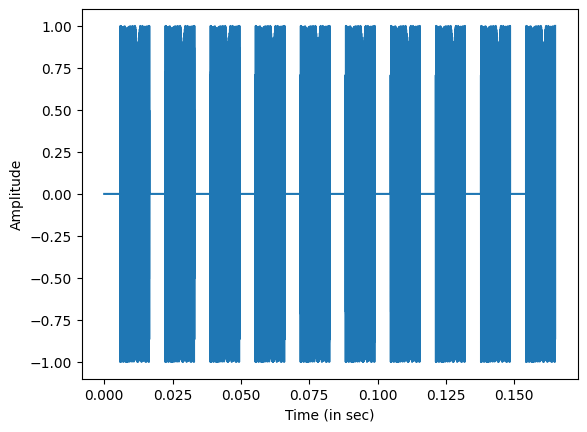

In [158]:
# Time vs Amplitude plot
plt.plot([i/sample_rate for i in range(len(chirp_rec))], chirp_rec)
plt.xlabel("Time (in sec)")
plt.ylabel("Amplitude")

In [159]:
F_in,A_in = compute_fft(signal, sample_rate)
F_out,A_out = compute_fft(chirp_rec, sample_rate)

print("Maximum frequency in input signal: ", F_in[np.argmax(A_in)])
print("Maximum frequency in output signal: ", F_out[np.argmax(A_out)])
print("Difference of frequency (beat freq): ", np.abs(F_in[np.argmax(A_in)] - F_out[np.argmax(A_out)]))

Maximum frequency in input signal:  18375.0
Maximum frequency in output signal:  19636.363636363636
Difference of frequency (beat freq):  1261.363636363636


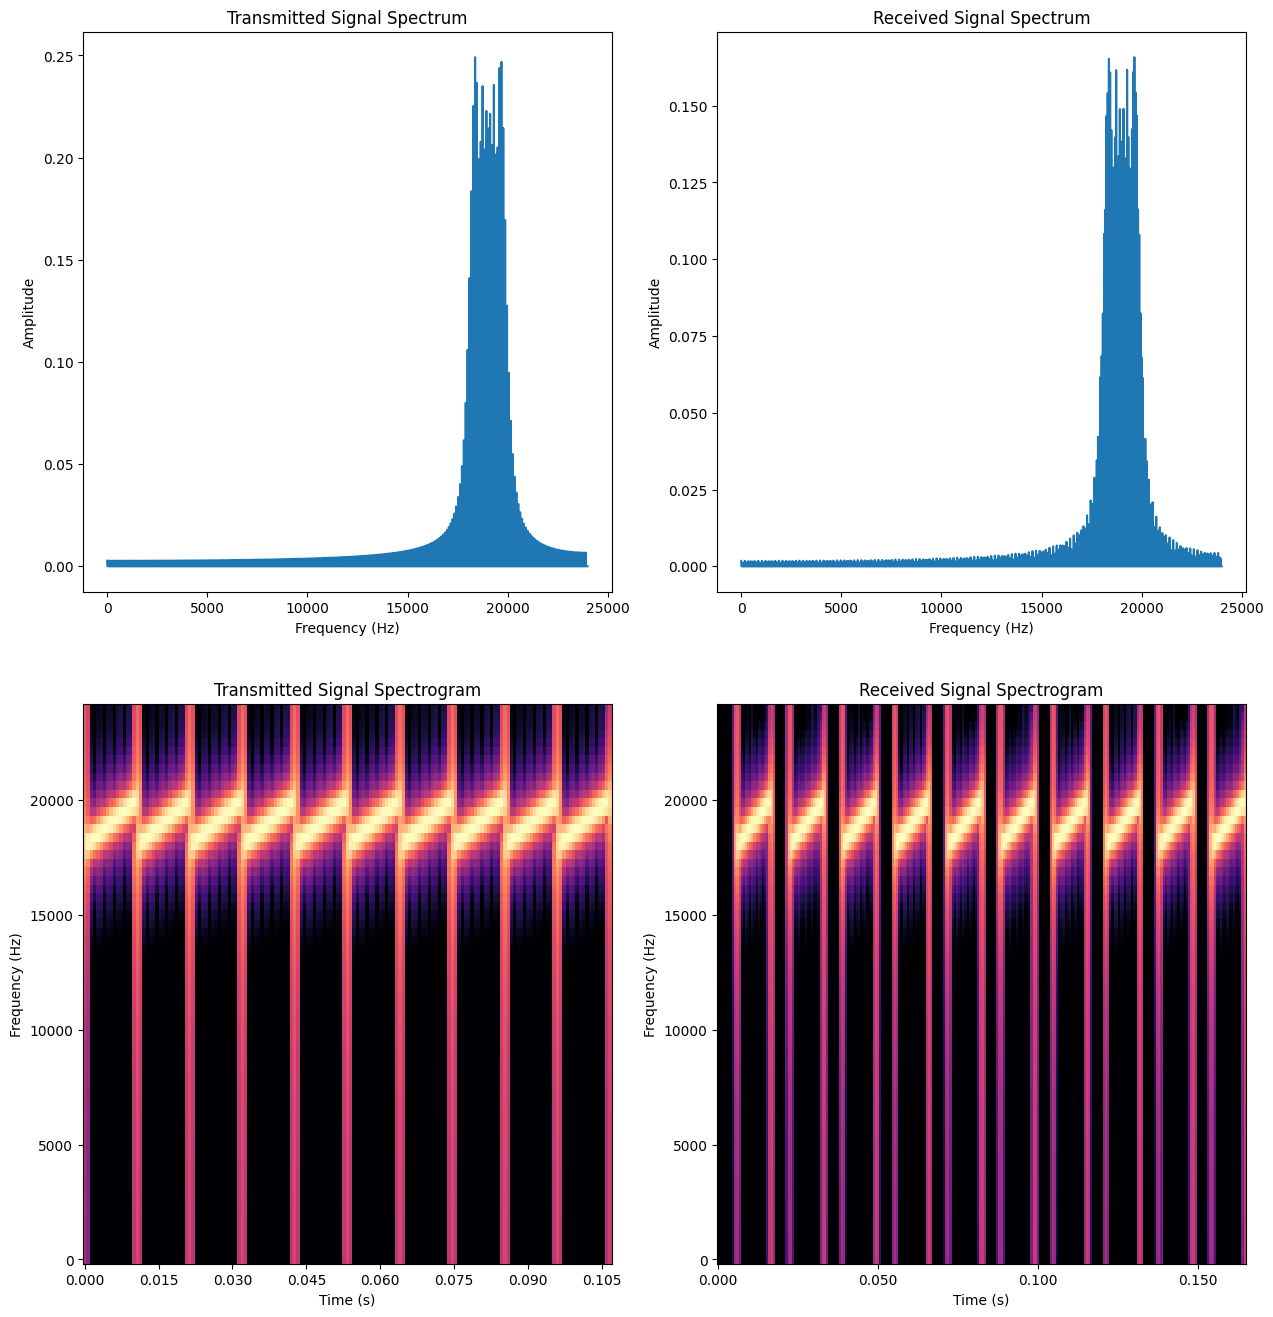

In [160]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(15, 16))

ax1.plot(F_in,A_in)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Transmitted Signal Spectrum')

ax2.plot(F_out,A_out)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Received Signal Spectrum')

plot_spectogram(signal,sample_rate, n_fft=128, title='Transmitted Signal Spectrogram', ax=ax3)
ax3.set_title('Transmitted Signal Spectrogram')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')

plot_spectogram(chirp_rec,sample_rate, n_fft=128, title='Received Signal Spectrogram', ax=ax4)

Text(0, 0.5, 'Amplitude')

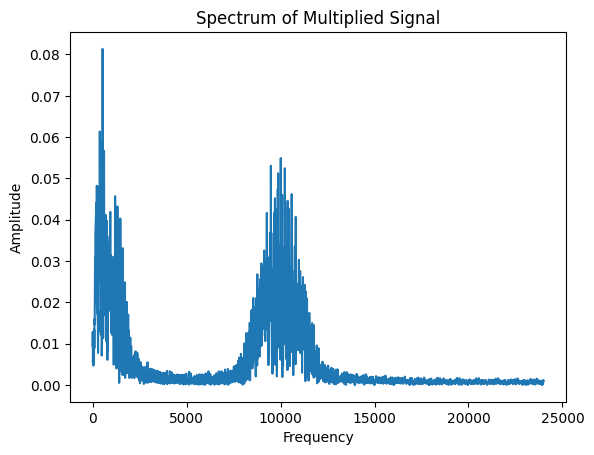

In [161]:
if signal.shape[0] < chirp_rec.shape[0]:
    chirp_rec = chirp_rec[:signal.shape[0]]
else:
    signal = signal[:chirp_rec.shape[0]]

#mixed = signal[280:] * chirp_rec[280:512] # overlapping part
mixed = signal[:] * chirp_rec[:] # overlapping part
F,A = compute_fft(mixed, sample_rate)
plt.plot(F,A)
#plt.xlim(0,3000)
#plt.xlim(7000, 15000)
plt.title("Spectrum of Multiplied Signal")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

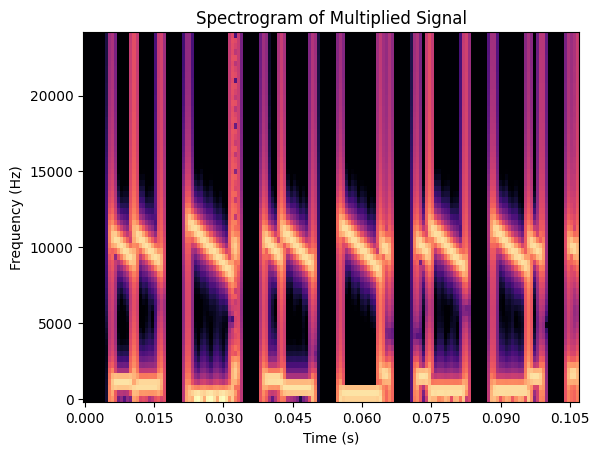

In [162]:
plot_spectogram(mixed, sample_rate, title="Spectrogram of Multiplied Signal")
#plt.ylim(0,5000)

In [163]:
cutoff = (186046.511 * delay_duration) 
if_signal = butter_lowpass_filter(mixed, cutoff, sample_rate, 5)

534.375


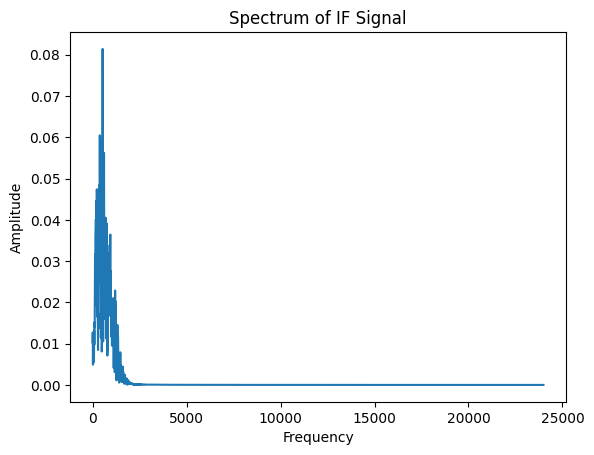

In [164]:
F_filtered,A_filtered = compute_fft(if_signal, sample_rate)
plt.plot(F_filtered,A_filtered)
#plt.xlim(0,3000)
#plt.xlim(7000, 15000)
plt.title("Spectrum of IF Signal")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

print(F_filtered[np.argmax(A_filtered)])

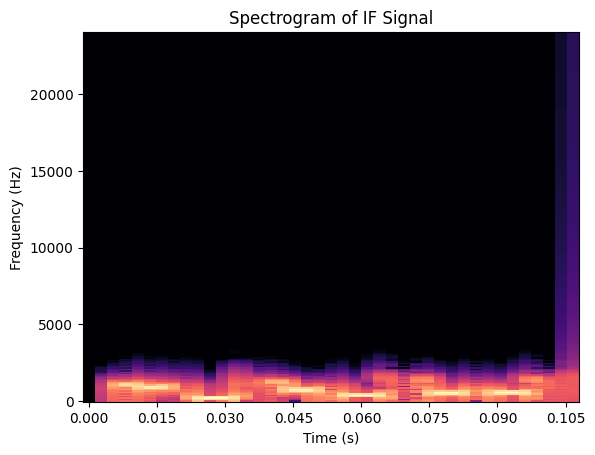

In [168]:
plot_spectogram(if_signal, sample_rate, title="Spectrogram of IF Signal", n_fft=512)